In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train.csv
/kaggle/input/test.csv



Bir Instagram hesabının gerçekliğini kesin bir şekilde belirlemek zordur. Ancak, belirli hesap özellikleri ve etkinlikleri temel alınarak, bir Instagram hesabının sahte olma olasılığını tahmin edebilen bir model oluşturmak mümkündür.

Bir sahte Instagram hesabı tespit modeli için giriş özellikleri olarak kullanılabilecek bazı olası özellikler şunlardır:

- Hesabın sahip olduğu takipçi sayısı
- Takipçiye göre takip edilenlerin oranı
- Hesabın yaşı
- Hesaptaki etkinlik miktarı (örneğin, gönderi sayısı, yorumlar, beğeniler)
- Paylaşılan içerik türü
- Hashtag kullanımı
- Profil resmi ve biyografinin varlığı
- Hesabın etkinliğini artırmak için üçüncü taraf uygulamaların kullanımı

Bu ve diğer ilgili özellikler kullanılarak, bir makine öğrenimi modeli eğitilerek bir Instagram hesabının sahte olma olasılığını tahmin etmek mümkündür. Ancak, doğru bir sahte Instagram hesabı tespit modeli oluşturmak için gerçek ve sahte hesapların büyük ve çeşitli bir veri setine, dikkatli bir özellik mühendisliğine ve model seçimine ihtiyaç vardır. Ayrıca, sahte hesapların zaman içinde evrimleşip değiştiği göz önüne alındığında, modelin sürekli olarak güncellenmesi önemlidir.


In [87]:
import warnings

warnings.filterwarnings("ignore")


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    fxn()

*   `profile pic`: Profil resminin olup olmadığı (1 var, 0 yok)
*   `nums/length username`: Kullanıcı adındaki sayıların oranı
*   `fullname words`: Tam adın kelime sayısı
*   `nums/length fullname`: Tam adındaki sayıların oranı
*   `name==username`: Tam adın kullanıcı adıyla aynı olup olmadığı (1 evet, 0 hayır)
*   `description length`: Açıklama uzunluğu
*   `external URL`: Harici URL'nin olup olmadığı (1 var, 0 yok)
*   `private`: Hesabın özel olup olmadığı (1 özel, 0 değil)
*   `#posts`: Gönderi sayısı
*   `#followers`: Takipçi sayısı
*   `#follows`: Takip edilen kişi sayısı
*   `fake`: Hesabın sahte olup olmadığı (1 sahte, 0 gerçek)

In [88]:


# Veri setlerini yükleme
train_data = pd.read_csv("/kaggle/input/train.csv")
test_data = pd.read_csv("/kaggle/input/test.csv")



In [89]:
train_data.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [90]:
train_data.tail()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1
575,1,0.27,1,0.00,0,0,0,0,2,150,487,1


In [91]:
train_data.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [92]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


In [93]:
train_data.isnull().sum()

profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64

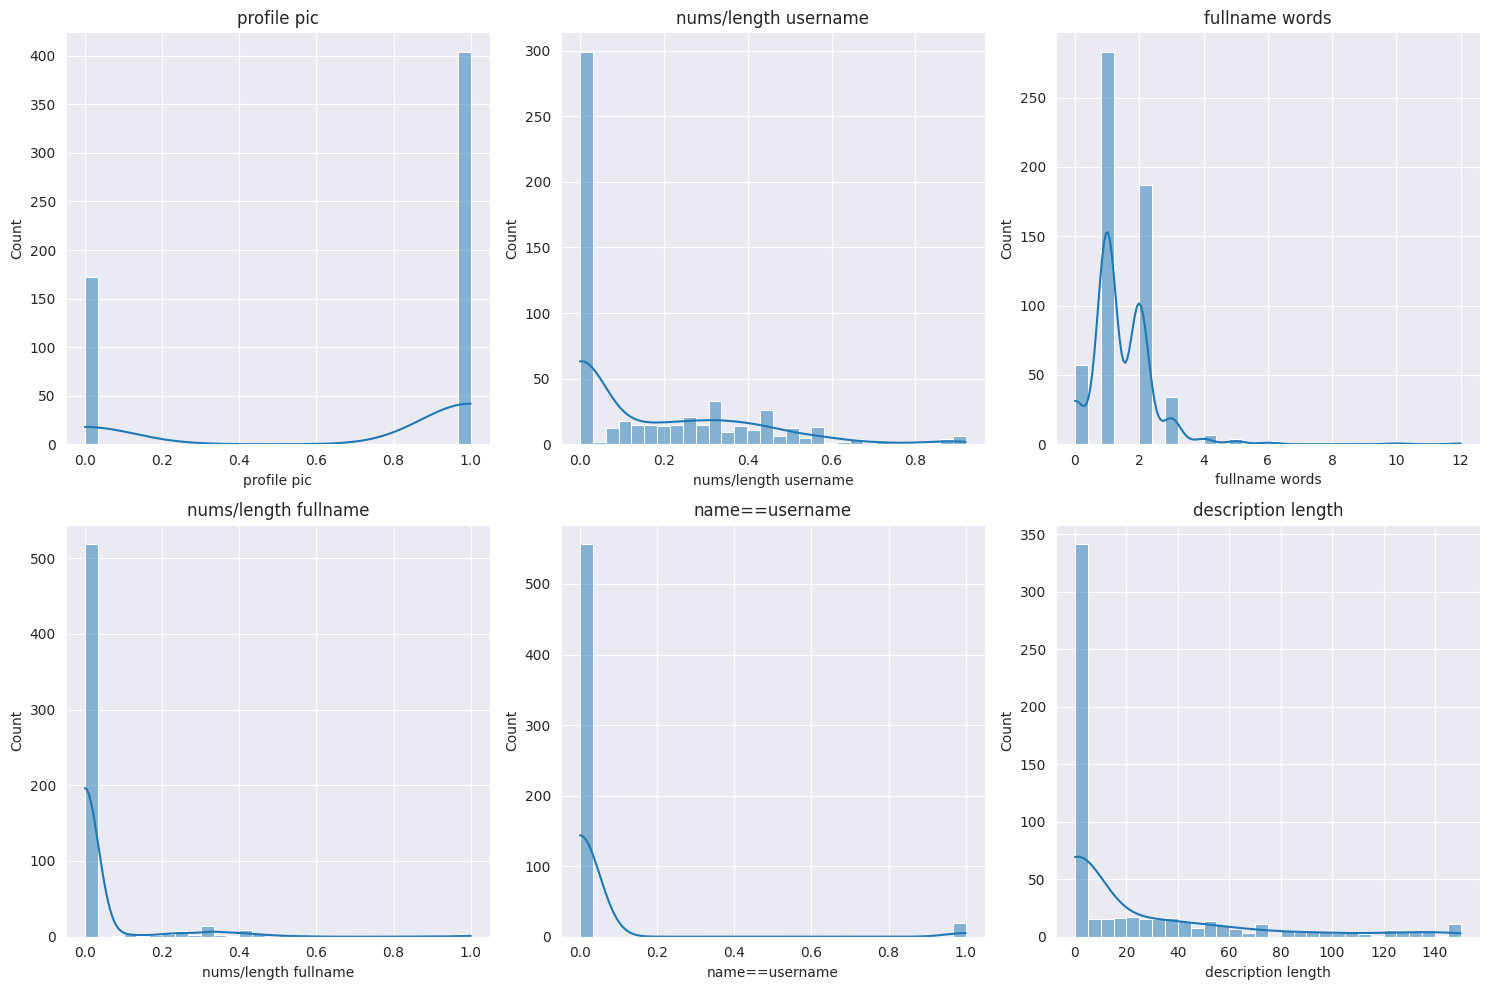

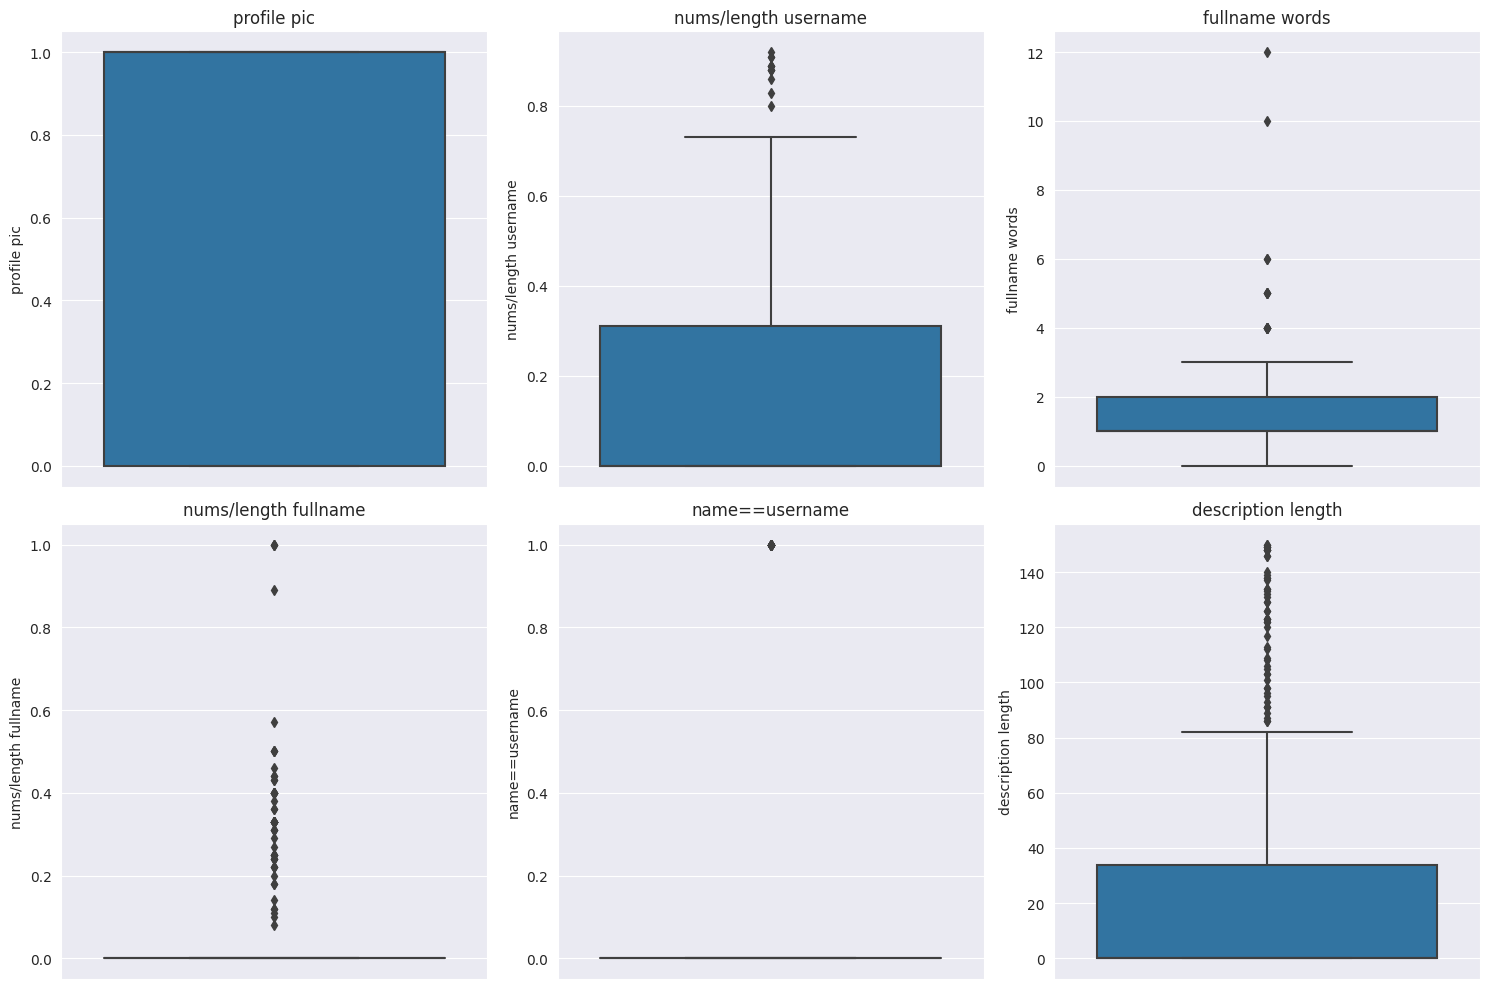

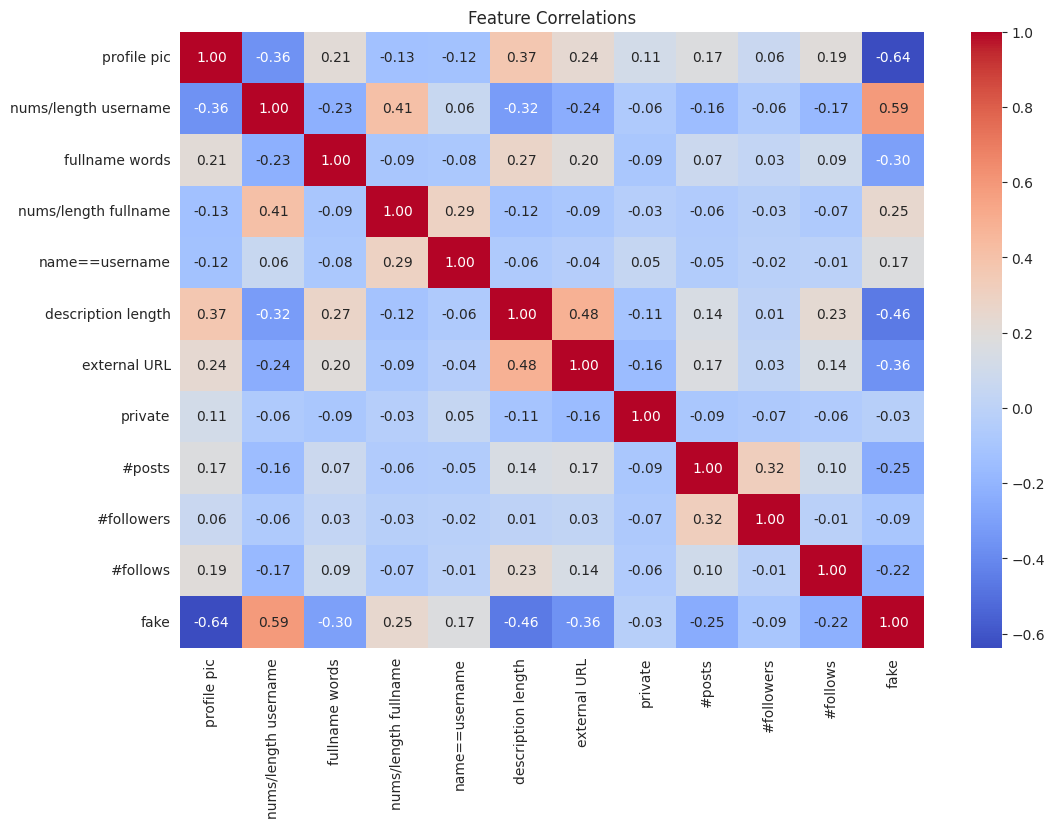

In [94]:

train_stats = train_data.describe()

def plot_feature_distributions(df, features, rows, cols, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    for i, feature in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(feature)
    plt.tight_layout()
    plt.show()

plot_feature_distributions(train_data, train_data.columns[:6], 2, 3)

def plot_box_plots(df, features, rows, cols, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    for i, feature in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        sns.boxplot(y=df[feature])
        plt.title(feature)
    plt.tight_layout()
    plt.show()


plot_box_plots(train_data, train_data.columns[:6], 2, 3)


correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlations")
plt.show()


sürekli değişkenlerin (description length, #posts, #followers, #follows) oldukça çarpık dağılımlara sahip olduğunu gösteriyor. Bu tür dağılımlar, bazı makine öğrenimi algoritmalarının performansını olumsuz etkileyebilir. Bu nedenle, bu özelliklerin ölçeklendirilmesi veya normalleştirilmesi gerekebilir.

In [95]:

train_duplicated = train_data[train_data.duplicated(keep=False)]
train_duplicated

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
196,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
197,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
491,1,0.91,1,0.0,0,0,0,0,0,75,26,1
525,1,0.91,1,0.0,0,0,0,0,0,75,26,1


In [96]:

test_duplicated = test_data[test_data.duplicated(keep=False)]
test_duplicated

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
61,1,0.27,1,0.0,0,0,0,0,0,45,64,1
63,0,0.00,1,0.0,1,0,0,0,0,69,694,1
67,0,0.00,1,0.0,1,0,0,0,0,69,694,1
83,1,0.27,1,0.0,0,0,0,0,0,45,64,1



Tekrar eden satırlar overfitting sorununa sebep olabilir bu yüzden onları siliyoruz.

In [97]:

train_data.drop_duplicates(inplace = True)
test_data.drop_duplicates(inplace = True)

print('\n')
print(f'Eğitim verisi yeni satır sayısı: {train_data.shape[0]}')
print(f'test verisi yeni satır sayısı: {test_data.shape[0]}')



Eğitim verisi yeni satır sayısı: 574
test verisi yeni satır sayısı: 118


In [98]:
def categorize_features(df):
    feature_types = {'binary_features': [], 'continuous_features': []}
    for col in df.columns:
        feature_category = 'binary_features' if df[col].nunique() <= 2 else 'continuous_features'
        feature_types[feature_category].append(col)

    return feature_types['continuous_features'], feature_types['binary_features']


In [99]:


continuous_features, binary_features = categorize_features(train_data)


print('\nContinuous features:')
for feature in continuous_features:
    print(feature)

print('\nBinary features:')
for feature in binary_features:
    print(feature)


Continuous features:
nums/length username
fullname words
nums/length fullname
description length
#posts
#followers
#follows

Binary features:
profile pic
name==username
external URL
private
fake


In [100]:
import plotly.express as px


if 'fake' in binary_features:
    binary_features.remove('fake')

legend_df = train_data.copy()
legend_df['fake'] = legend_df['fake'].replace({0: 'Real Accounts', 1: 'Fake Accounts'}) 

# Function to plot barplots
def create_barplots(df, legend_df, binary_features):
    for feature in binary_features:
        fig = px.histogram(df, x=feature, color=legend_df['fake'],
                           color_discrete_sequence=['#636EFA','#EF553B'],
                           barmode='group', template='plotly_white', labels={'color': 'Real/Fake'})
        
        fig.update_layout(title=f'{feature} Distribution',
                          xaxis_title=feature, yaxis_title='Count',
                          xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['No', 'Yes']),
                          height=650)
        
        fig.show()

create_barplots(train_data, legend_df, binary_features)

*  Profil resmi olmayan hesapların çoğu sahte hesaplardır.
    
*   Genellikle, adı kullanıcı adıyla aynı olan hesaplar da sahte hesaplardır.
    
*   Şaşırtıcı bir şekilde, biyografilerinde dış URL'ye sahip olan hesapların tümü gerçek hesaplarmış gibi görünüyor. Genel olarak, çoğu hesabın dış bir URL'si bulunmamaktadır.
    
*   Özel olmayan hesapların çoğu sahte hesaplardır, oysa gerçekten özel olanların çoğu gerçek hesaplardır.

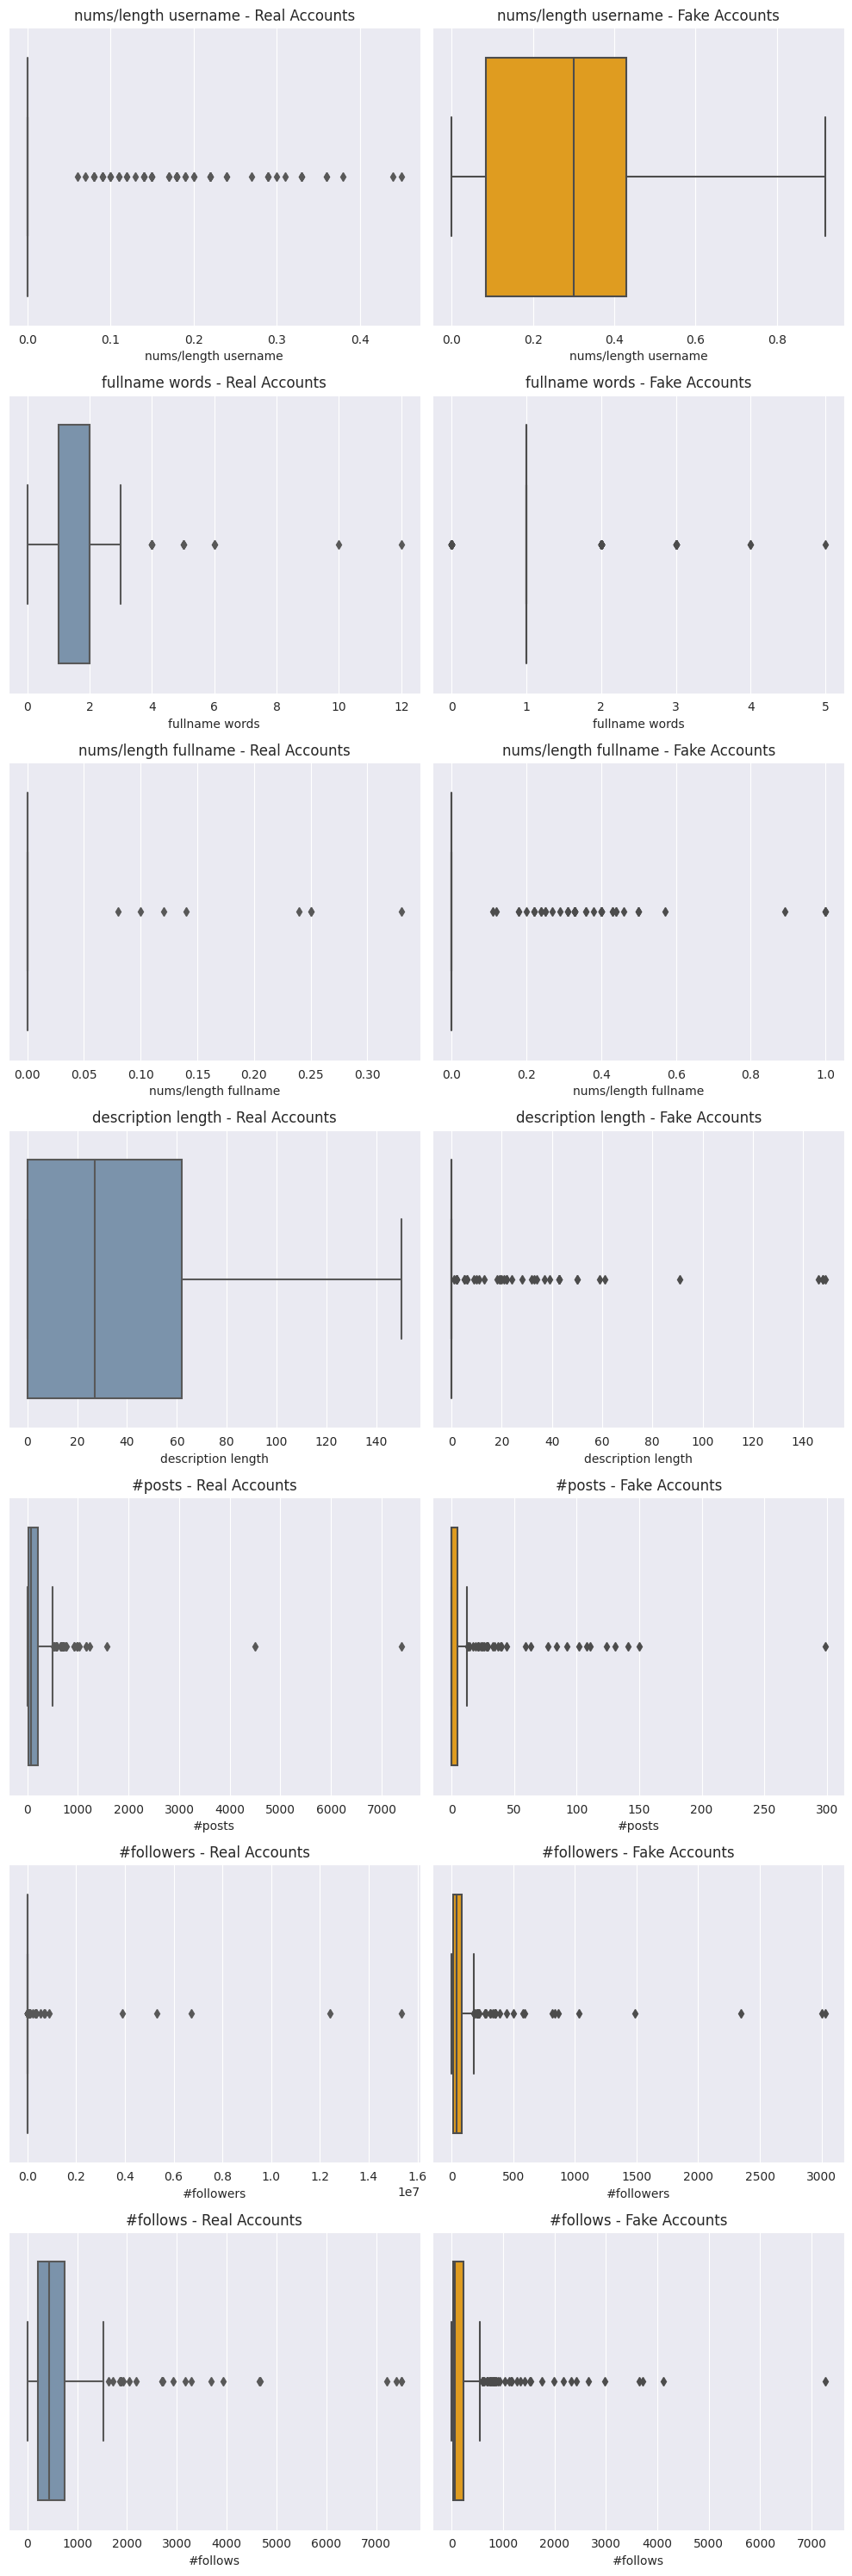

In [101]:

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=2, figsize=(10, 30))

# Loop through each continuous feature
for i, col in enumerate(continuous_features):
    # Iterate over 'fake' values (0 or 1)
    for j, fake_status in enumerate([0, 1]):
        color = '#7393B3' if fake_status == 0 else 'orange'
        title = f"{col} - {'Real' if fake_status == 0 else 'Fake'} Accounts"

        sns.boxplot(data=train_data[train_data['fake'] == fake_status], x=col, ax=axes[i, j], color=color)
        axes[i, j].set_title(title)

plt.tight_layout()
plt.show()


*   Sahte hesapların kullanıcı adlarında genellikle daha fazla sayısal karakter oranı bulunmaktadır.
    
*   Sahte hesaplar, tam adlarında daha az kelimeye sahip olma eğilimindedir.
    
*   Outliners hariç tutulduğunda, sahte hesapların açıklamaları/biyografileri genellikle çok daha kısadır.
    
*   Gerçek hesaplar, sahte hesaplara göre çok daha fazla gönderiye sahiptir.
    
*   Gerçek hesaplar, sahte hesaplardan çok daha fazla takipçiye sahiptir.
    
*   Genel olarak, Outliners dışında bırakıldığında, ortalama olarak çoğu sahte hesabın gerçek hesaplara kıyasla daha az kişiyi takip ettiği görülmektedir.


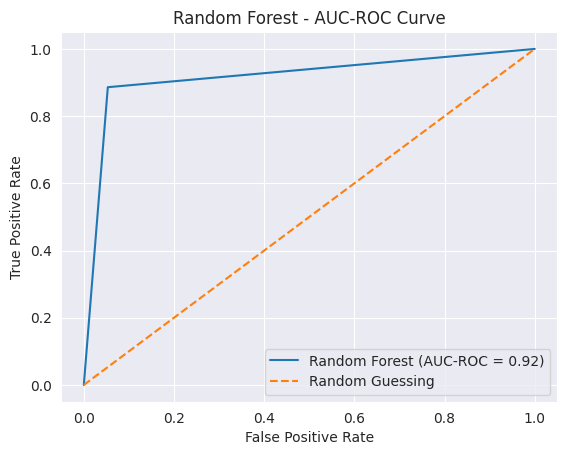


Random Forest - y_val value counts:
fake
0    94
1    79
Name: count, dtype: int64

Random Forest - predicted value counts:
(array([0, 1]), array([98, 75]))

---------------------------------------------



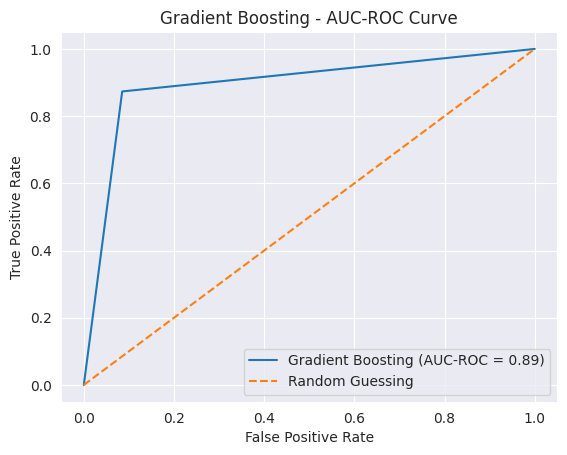


Gradient Boosting - y_val value counts:
fake
0    94
1    79
Name: count, dtype: int64

Gradient Boosting - predicted value counts:
(array([0, 1]), array([96, 77]))

---------------------------------------------



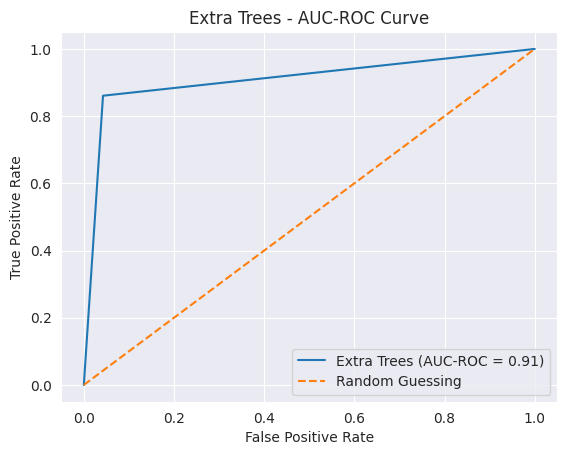


Extra Trees - y_val value counts:
fake
0    94
1    79
Name: count, dtype: int64

Extra Trees - predicted value counts:
(array([0, 1]), array([101,  72]))

---------------------------------------------



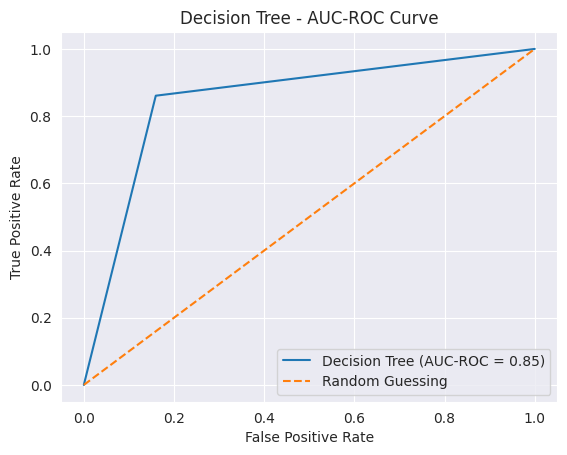


Decision Tree - y_val value counts:
fake
0    94
1    79
Name: count, dtype: int64

Decision Tree - predicted value counts:
(array([0, 1]), array([90, 83]))

---------------------------------------------



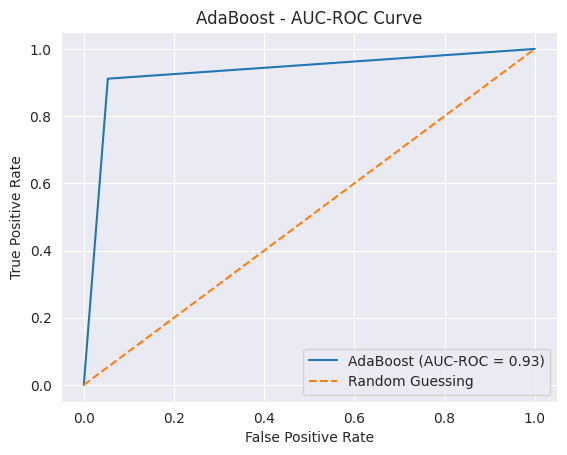


AdaBoost - y_val value counts:
fake
0    94
1    79
Name: count, dtype: int64

AdaBoost - predicted value counts:
(array([0, 1]), array([96, 77]))

---------------------------------------------



In [102]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost modelini ekleyin

rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
et_model = ExtraTreesClassifier(random_state=42)
ab_model = AdaBoostClassifier(random_state=42)




models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Extra Trees": et_model,
    "Decision Tree": dt_model,
    "AdaBoost": ab_model
}

# Veri setini hazırlama
X = train_data.drop('fake', axis=1)
y = train_data['fake']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelleri eğitin ve ROC-AUC grafiklerini çizin
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # ROC Curve ve AUC hesaplama
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds})
    auc_score = roc_auc_score(y_val, y_pred)

    # ROC Curve çizimi
    sns.set_style('darkgrid')
    sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f'{name} (AUC-ROC = {auc_score.round(2)})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
    plt.title(f'{name} - AUC-ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Değerlendirmeler
    print(f'\n{name} - y_val value counts:')
    print(y_val.value_counts())
    print(f'\n{name} - predicted value counts:')
    print(np.unique(y_pred, return_counts=True))
    print("\n---------------------------------------------\n")





Şimdi, özellik seçimi için, hedef değişkeni tahmin etmede her bir özelliğin gösterdiği önemi içeren bir çubuk grafiği çizmek üzere SHAP kütüphanesini kullanabiliriz.

5 modelin sonuçlarına baktığımızda, her birinin tahmin başarısı ve özelliklerin önem sıralaması açısından farklılık gösterdiğini görüyoruz. 'Random Forest' modeli, özellikle sahte hesapları tespit etmede yüksek doğrulukla öne çıktı. 'Decision Tree' ise karar ağacının doğası gereği, özellikle belli özellikler üzerinde yoğunlaşarak tahminlerde bulundu." Genel olarak hepsi başarılı sonuç verdi. 

**Şimdi modellerin hangi özellikleri (Feature) daha fazla kullandığına bakalım.**

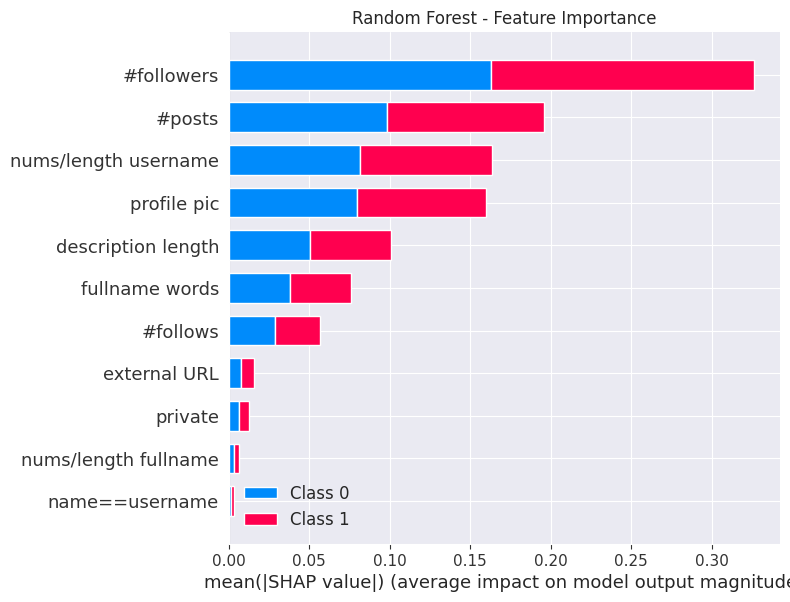

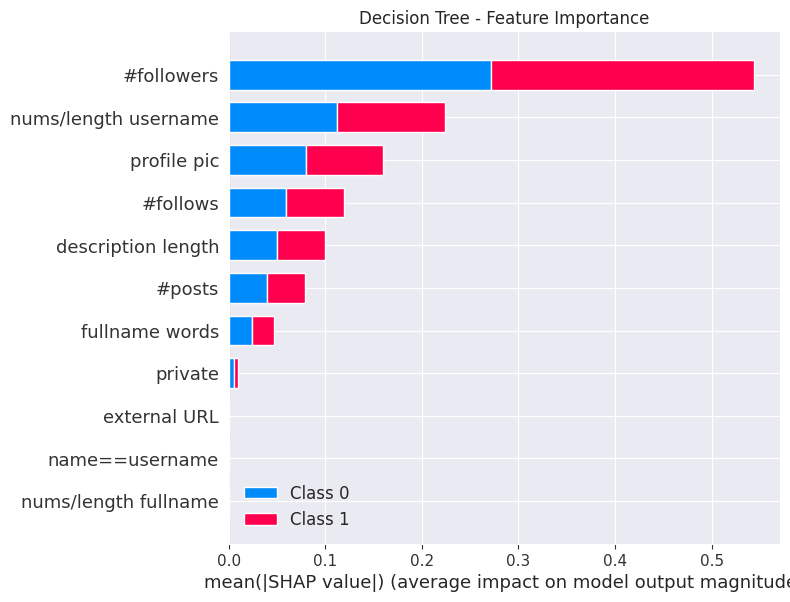

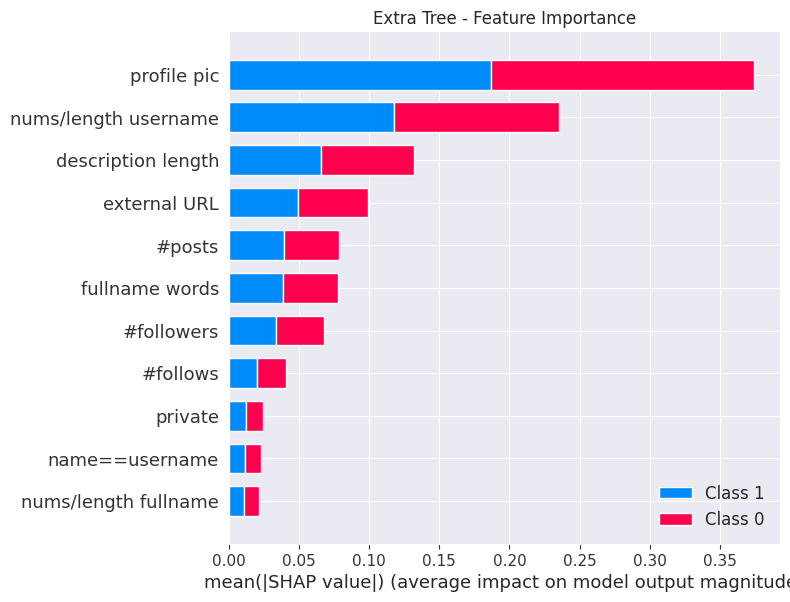

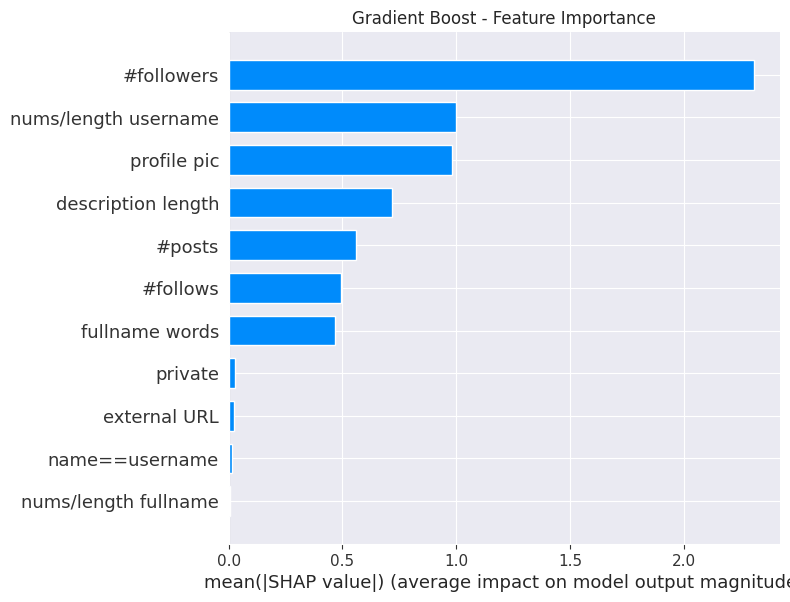

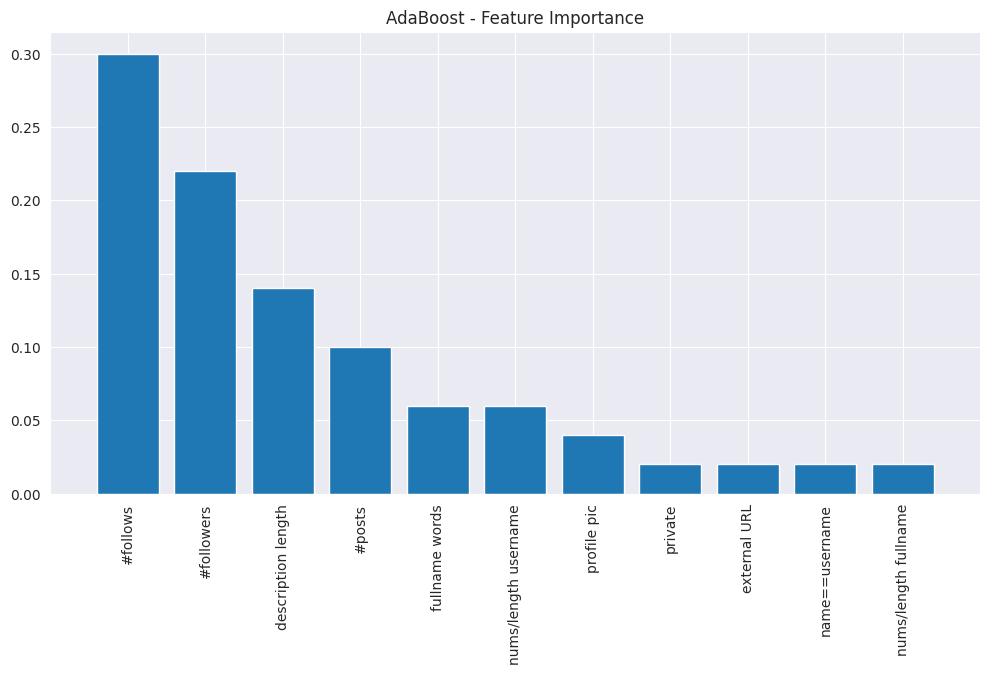

In [103]:
import shap

# Random Forest için SHAP Değerleri
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_val)
shap.summary_plot(rf_shap_values, X_val, plot_type="bar", show=False)
plt.title("Random Forest - Feature Importance")
plt.show()

# Decision Tree için SHAP Değerleri
dt_explainer = shap.TreeExplainer(dt_model)
dt_shap_values = dt_explainer.shap_values(X_val)
shap.summary_plot(dt_shap_values, X_val, plot_type="bar", show=False)
plt.title("Decision Tree - Feature Importance")
plt.show()

# Extra Tree için SHAP Değerleri
dt_explainer = shap.TreeExplainer(et_model)
dt_shap_values = dt_explainer.shap_values(X_val)
shap.summary_plot(dt_shap_values, X_val, plot_type="bar", show=False)
plt.title("Extra Tree - Feature Importance")
plt.show()

# Gradient Boost için SHAP Değerleri
dt_explainer = shap.TreeExplainer(gb_model)
dt_shap_values = dt_explainer.shap_values(X_val)
shap.summary_plot(dt_shap_values, X_val, plot_type="bar", show=False)
plt.title("Gradient Boost - Feature Importance")
plt.show()

# Gradient Boost için SHAP Değerleri
#Adaboost modelinin shap değerlerini doğrudan hesaplayamıyoruz

import matplotlib.pyplot as plt

# AdaBoost modeli için özellik önemliliği
feature_importances = ab_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# En önemli özelliklerin görselleştirilmesi
plt.figure(figsize=(12, 6))
plt.title("AdaBoost - Feature Importance")
plt.bar(range(X_val.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_val.shape[1]), X_val.columns[indices], rotation=90)
plt.xlim([-1, X_val.shape[1]])
plt.show()



"Genel olarak, tüm özelliklerin çıktıyı bir şekilde etkilediği görülüyor, bu nedenle hiçbir özelliğin gereksiz yük oluşturmadığını söyleyebiliriz.

En önemli özellikleri öğrendiğimize göre, şimdi bu özelliklerden bazılarını kullanarak yeni özellikler oluşturabiliriz. Amacımız, son modelimizin tahmin yeteneklerini daha da güçlendirecek özellik mühendisliği yapmaktır."

**Feature Engineering**



Aktivite Oranı: Bu, bir hesabın gönderi aktivitesini takipçi sayısına göre ölçen basit bir yöntemdir. Aşağıdaki denkleme göre hesaplanır:

Aktivite Oranı = Gönderi Sayısı / Takipçi Sayısı

Takipçi > Takip Edilen?: Öncelikle, sahte hesapların çoğunun kendilerinin takip ettiği kişi sayısından çok daha az takipçiye sahip olacağını düşünüyorum. Bu nedenle bu ikili özellik, her hesap için 0 veya 1 olarak etiketlenecek. Burada 1, belirli bir hesabın takip ettiğinden daha fazla takipçisi olduğunu gösterecek. Bu, hedef tahmini için önemli bir özellik olabilir.

In [104]:
train_data['aktivite_orani'] = np.round(train_data['#posts'] / train_data['#followers'], 2)
train_data['takipci_takipEdilen'] = (train_data['#followers'] > train_data['#follows']).astype(int)

In [105]:
train_data.tail()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,aktivite_orani,takipci_takipEdilen
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1,0.20,0
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1,0.67,0
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1,0.04,0
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1,0.00,0
575,1,0.27,1,0.00,0,0,0,0,2,150,487,1,0.01,0


In [106]:
train_data.isnull().sum()


profile pic              0
nums/length username     0
fullname words           0
nums/length fullname     0
name==username           0
description length       0
external URL             0
private                  0
#posts                   0
#followers               0
#follows                 0
fake                     0
aktivite_orani          15
takipci_takipEdilen      0
dtype: int64

In [107]:
train_data.isin([np.inf, -np.inf]).sum()


profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
aktivite_orani          3
takipci_takipEdilen     0
dtype: int64

In [108]:
# post / takipçi yaptığımız için takipçinin 0 olma olasılığı var bu yüzden. Sonsuz değerleri NAN ile
#değiştiriyoruz
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# sonrada NAN değerlerini kaldırıyoruz
train_data.dropna(inplace=True)

In [109]:
# standart sapma ve ortalama
train_data_means = train_data.mean().round(2)
train_data_stds = train_data.std().round(2)
results = pd.concat([train_data_means, train_data_stds], axis = 1)
results.columns = ['Mean', 'Standard Deviation']
results

,Mean,Standard Deviation
profile pic,0.72,0.45
nums/length username,0.16,0.21
fullname words,1.47,1.06
nums/length fullname,0.04,0.13
name==username,0.03,0.18
description length,23.27,38.13
external URL,0.12,0.33
private,0.37,0.48
#posts,110.94,408.69
#followers,88366.21,926256.64


from sklearn.tree import DecisionTreeClassifier

In [110]:


X = train_data.drop('fake', axis=1)
y = train_data['fake']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35, random_state=123)

pipelines = {
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()), 
        ("model", RandomForestClassifier(random_state=42))
    ]),
    "Extra Trees": Pipeline([
        ("scaler", StandardScaler()), 
        ("model", ExtraTreesClassifier(random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("scaler", StandardScaler()), 
        ("model", GradientBoostingClassifier(random_state=42))
    ]),
    "Decision Tree": Pipeline([
        ("scaler", StandardScaler()), 
        ("model", DecisionTreeClassifier(random_state=42)),
        
    ]),
    "Ada Boost": Pipeline([
        ("scaler", StandardScaler()), 
        ("model", AdaBoostClassifier(random_state=42)),
        
    ])
}

# Her bir model için hiperparametre ayarlama ve çapraz doğrulama yapma
param_grids = {
    "Random Forest": {'model__n_estimators': [100, 200, 300]},
    "Extra Trees": {'model__n_estimators': [100, 200, 300]},
    "Gradient Boosting": {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 1]},
    "Decision Tree": {'model__max_depth': [5, 10, 15]},
     "AdaBoost": {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1]}
        
    
}

optimized_models = {}
for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)
        optimized_models[name] = pipeline
        y_val_pred = pipeline.predict(X_val)
        val_auc = roc_auc_score(y_val, y_val_pred)
        print(f"{name} AUC-ROC score: {val_auc:.2f}")

        
# Test verileri için hazırlık
test_data['aktivite_orani'] = np.round(test_data['#posts'] / test_data['#followers'], 2)
test_data['takipci_takipEdilen'] = (test_data['#followers'] > test_data['#follows']).astype(int)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.dropna(inplace=True)

X_test = test_data.drop('fake', axis = 1) 
y_test = test_data.fake
print("\n\n")
# Test veri seti üzerinde tahminlerde bulunma
for name, model in optimized_models.items():
    y_test_pred = model.predict(X_test)
    test_auc = roc_auc_score(y_test, y_test_pred)
    print(f"{name} on test data: AUC-ROC score = {test_auc:.2f}")


Random Forest AUC-ROC score: 0.90
Extra Trees AUC-ROC score: 0.91
Gradient Boosting AUC-ROC score: 0.89
Decision Tree AUC-ROC score: 0.82
Ada Boost AUC-ROC score: 0.89



Random Forest on test data: AUC-ROC score = 0.94
Extra Trees on test data: AUC-ROC score = 0.92
Gradient Boosting on test data: AUC-ROC score = 0.92
Decision Tree on test data: AUC-ROC score = 0.88
Ada Boost on test data: AUC-ROC score = 0.90


In [111]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Voting ve Stacking Ensemble Modellerini Oluşturma
voting_clf_hard = VotingClassifier(
    estimators=[('rf', optimized_models['Random Forest']), 
                ('et', optimized_models['Extra Trees']), 
                ('gb', optimized_models['Gradient Boosting']), 
                ('dt', optimized_models['Decision Tree']),
    ('at', optimized_models['Ada Boost'])],
    voting='hard')

stacking_clf = StackingClassifier(
    estimators=[('rf', optimized_models['Random Forest']),
                 ('et', optimized_models['Extra Trees']), 
                ('gb', optimized_models['Gradient Boosting']), 
                ('dt', optimized_models['Decision Tree']),
                ('at', optimized_models['Ada Boost'])],
    
    final_estimator=LogisticRegression())


# Her toplu modeli eğitme ve doğrulama veri seti üzerinde değerlendirme
for clf in [voting_clf_hard, stacking_clf]:
    clf_name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    val_auc = roc_auc_score(y_val, y_val_pred)
    print(f"{clf_name} on validation data: AUC-ROC Score = {val_auc:.2f}")
    
# test
for clf in [voting_clf_hard, stacking_clf]:
    clf_name = clf.__class__.__name__
    y_pred = clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)

    print(f"{clf_name} on test data: AUC-ROC score = {auc:.2f}")



VotingClassifier on validation data: AUC-ROC Score = 0.90
StackingClassifier on validation data: AUC-ROC Score = 0.91
VotingClassifier on test data: AUC-ROC score = 0.91
StackingClassifier on test data: AUC-ROC score = 0.91


In [112]:
#2 tane gerçek veri ile test ediyoruz. 


fake = [0, 0.13, 2, 0.0, 0, 12, 1, 0, 0, 0, 901, 0, 0]
real = [1, 0.1, 1, 0.0, 0, 11, 1, 1, 2, 335, 291, 0.01, 1]

real_df = pd.DataFrame([real])
fake_df = pd.DataFrame([fake])

for name, pipeline in optimized_models.items():
    real_pred = pipeline.predict(real_df)
    print(f"0 - {name} = {real_pred[0]}")

print("\n\n")
for name, pipeline in optimized_models.items():
    fake_pred = pipeline.predict(fake_df)
    print(f"1 - {name} = {fake_pred[0]}")

print('\n\n')
for clf in [voting_clf_hard, stacking_clf]:
    clf_name = clf.__class__.__name__
    y_pred = clf.predict(fake_df)
    print(f"1 - {clf_name} = {y_pred[0]}")
    
    
print('\n\n')
for clf in [voting_clf_hard, stacking_clf]:
    clf_name = clf.__class__.__name__
    y_pred = clf.predict(real_df)
    print(f"0 - {clf_name} = {y_pred[0]}")
   

0 - Random Forest = 0
0 - Extra Trees = 0
0 - Gradient Boosting = 0
0 - Decision Tree = 0
0 - Ada Boost = 0



1 - Random Forest = 1
1 - Extra Trees = 1
1 - Gradient Boosting = 1
1 - Decision Tree = 1
1 - Ada Boost = 1



1 - VotingClassifier = 1
1 - StackingClassifier = 1



0 - VotingClassifier = 0
0 - StackingClassifier = 0


VotingClassifier ve StackingClassifier modellerinin tahmin değerleri yeterince yüksek. İkisinden birini uygulamamızda kullanabiliriz.

In [113]:
import pickle

for name, pipeline in optimized_models.items():
    name = f"{name}.pkl"
    with open(name, 'wb') as file:  
        pickle.dump(pipeline, file)

for clf in [voting_clf_hard, stacking_clf]:
    clf_name = clf.__class__.__name__
    with open(f'{clf_name}.pkl', 'wb') as file:
        pickle.dump(clf, file)
        
        

print("kaydedildi")


kaydedildi
